In [19]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
import gc
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [20]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [21]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 0
# Load data
nrows = 512
ncols = 512
nslices = 352
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/home/ali/RadDBS-QSM/data/nii/new_qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
s_directory = '/home/ali/RadDBS-QSM/data/nii/new_seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)

n_cases = 115

Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  OFF meds ON stim 6mo
{'Race', 'Ethnicity', 'Sex', ' Target', 'Physician', ' OFF (pre-dbs updrs)', ' ON (pre-dbs updrs)', ' pre op levadopa equivalent dose (mg)', 'Disease Duration (year)', ' OFF meds ON stim 6mo', ' Test medication status', 'Age', ' Location', 'CORNELL ID'}
Phi_01
Phi_02
Phi_03
Phi_04
Phi_05
Phi_06
Phi_07
Phi_08
Phi_09
Phi_10
Phi_11
Phi_12
Phi_13
Phi_14
Phi_15
Phi_16
Phi_17
Phi_19
Phi_20
Phi_22
Phi_24
Phi_25
Phi_26
Phi_27
Phi_29
Phi_30
Phi_32
Phi_33
Phi_34
Phi_36
Phi_37
Phi_39
Phi_40
Phi_41
Phi_42
Phi_44
Phi_45
Phi_46
Phi_50
Phi_51
Phi_52
Phi_53
Phi_56
Phi_57
Phi_58
Phi_59
Phi_60
Phi_61
Phi_62
Phi_63
Phi_64
Phi_66
Phi_67
Phi_68
Phi_69
Phi_72
Phi_73
Phi_74
Phi_75
Phi_76
Phi

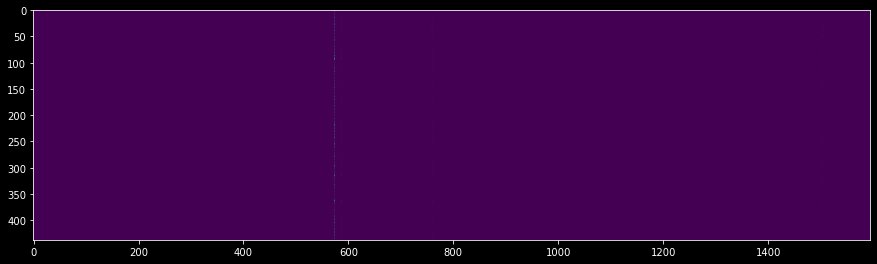

In [ ]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status'}


# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/home/ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
plt.imshow(X_all.reshape(-1,1595))
print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID']).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude location minority
# c_cases_idx[ids == 29] = 0
# c_cases_idx[ids == 44] = 0
# c_cases_idx[ids == 45] = 0
# c_cases_idx[ids == 46] = 0
# Exclude GPi
c_cases_idx[ids == 36] = 0
c_cases_idx[ids == 42] = 0
c_cases_idx[ids == 52] = 0
c_cases_idx[ids == 53] = 0
c_cases_idx[ids == 98] = 0
c_cases_idx[ids == 108] = 0
X_all_c = X_all[c_cases_idx,2:6,:]
# X_all_c = (np.load('X2h.npy').T).reshape((61,6381))
# print('Applying combat')
K_all_c = K_all[c_cases_idx,2:6,:]
R_all_c = R_all[c_cases_idx,2:6,:]
# Re-index the scored subjects with respect to complete cases

s_cases_idx = np.in1d(subs,ids[c_cases_idx])
per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]
phys = cv_dict['Physician'][s_cases_idx]
age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
subsc = subs[s_cases_idx]
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

print(np.unique(R_all_c))

In [23]:
per_change

array([0.70769231, 0.5       , 0.66666667, 0.77419355, 0.96825397,
       0.73809524, 0.70833333, 0.7826087 , 0.84848485, 0.56666667,
       0.74074074, 0.71428571, 0.8125    , 0.82142857, 0.66666667,
       0.88461538, 0.1875    , 0.84848485, 0.3030303 , 0.075     ,
       0.51724138, 0.74358974, 0.81081081, 0.53225806, 0.91176471,
       0.66153846, 0.53125   , 0.8       , 0.88571429, 0.26086957,
       0.8125    , 0.96774194, 0.55932203, 0.65517241, 0.52272727,
       0.83928571, 0.14705882, 0.5       , 0.08571429, 0.30232558])

In [24]:
per_change[per_change < 0.3]

array([0.1875    , 0.075     , 0.26086957, 0.14705882, 0.08571429])

In [25]:
n_cases = len(per_change)
# n_roisc = X_all_c.shape[1]
# n_features = X_all_c.shape[2]
results_ls_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
r = 1

In [26]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:]
    X_test = X_all_c[test_index,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,loc,tmed,dd,ledd,phys,None,None,None,None,False,False,False)
    # X0_ss0 = X_train
    # X_test_ss0 = X_test

    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    np.random.seed(rs)
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn: #2*np.sum(y_cat)-1
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
      if aug == True:
        y_train_n = y_train+(sigma/mu)*np.random.normal(0,4*sigma,1)
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)

      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls_aug[c] = est_ls.predict(X_test_ss)
    print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
              'for case',subsc[j], 'with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
  
    c=c+1

      
# Old data
  


Label distribution of: 0.6321651351845912 0.243410834901426 -0.8387907971979701


LassoCV score for 2 is [0.33731305] from dataset of size (312, 6386)
LassoCV score for 3 is [0.33775106] from dataset of size (312, 3386)
LassoCV score for 4 is [0.33874288] from dataset of size (312, 1386)
Lasso predicts 0.8962 for case 1.0 with 0.71 and selected CV 4
Label distribution of: 0.6374905789715734 0.2427320578527609 -0.9067651170238487
LassoCV score for 2 is [0.26883672] from dataset of size (312, 3386)
LassoCV score for 3 is [0.34162322] from dataset of size (312, 3386)
LassoCV score for 4 is [0.34376052] from dataset of size (312, 386)
Lasso predicts 0.2846 for case 2.0 with 0.5 and selected CV 4
Label distribution of: 0.6332170746980691 0.2436462015136146 -0.8486238582409412
LassoCV score for 2 is [0.33905482] from dataset of size (312, 2386)
LassoCV score for 3 is [0.33883487] from dataset of size (312, 2386)
LassoCV score for 4 is [0.25685846] from dataset of size (312, 4386)
Lasso predicts 0.6874 for case 6.0 with 0.67 and selected CV 2
Label distribution of: 0.63045

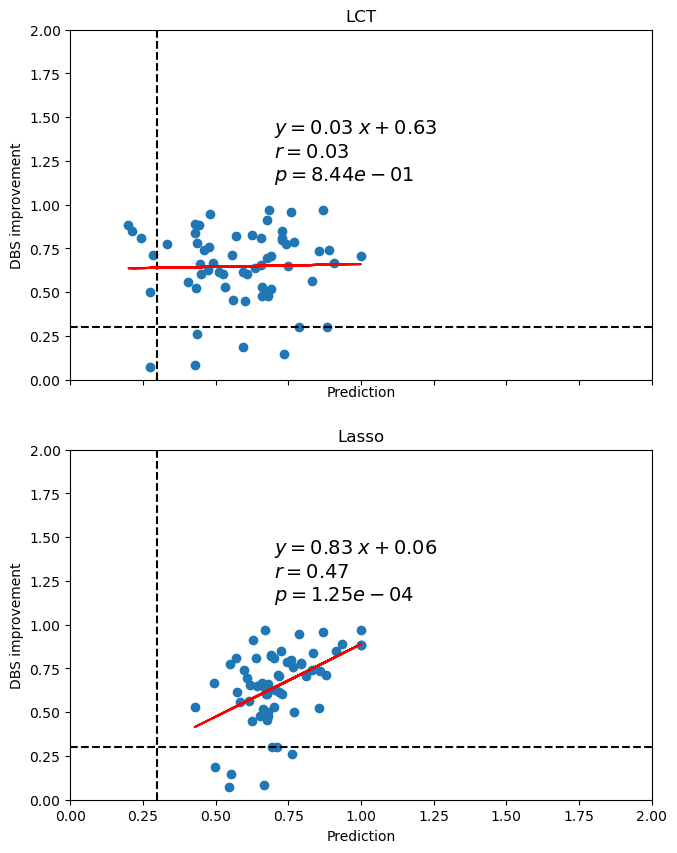

In [ ]:
results_ls_aug[results_ls_aug>1]=1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [ ]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:]
    X_test = X_all_c[test_index,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    N = np.sum(y_cat)
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,loc,tmed,dd,ledd,phys,None,None,None,None,False,False,False)
    # X0_ss0 = X_train
    # X_test_ss0 = X_test

    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    np.random.seed(rs)
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < 2*N-1: #2*np.sum(y_cat)-1
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
      if aug == True:
        y_train_n = y_train+(sigma/mu)*np.random.normal(0,4*sigma,1)
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)

      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls_aug[c] = est_ls.predict(X_test_ss)
    print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
              'for case',subsc[j], 'with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
  
    c=c+1

      

  


Label distribution of: 0.6471560005431053 0.21564013096418103 -0.8589531666768364
Resampled to size (61,)
Resampled to size (62,)
Resampled to size (63,)
Resampled to size (64,)
LassoCV score for 2 is [0.45860896] from dataset of size (512, 387)
LassoCV score for 3 is [0.53210742] from dataset of size (512, 1387)
LassoCV score for 4 is [0.53523026] from dataset of size (512, 1387)
Lasso predicts 0.6782 for case 1.0 with 0.71 and selected CV 4
Label distribution of: 0.6506175390046437 0.21491590549216863 -0.9102668435676828
Resampled to size (61,)
Resampled to size (62,)
Resampled to size (63,)
Resampled to size (64,)
LassoCV score for 2 is [0.54205303] from dataset of size (512, 5387)
LassoCV score for 3 is [0.54186329] from dataset of size (512, 6387)
LassoCV score for 4 is [0.54205334] from dataset of size (512, 1387)
Lasso predicts 0.681 for case 2.0 with 0.5 and selected CV 4
Label distribution of: 0.6478397612268659 0.21576591836236428 -0.8666030314815965
Resampled to size (61,)
R

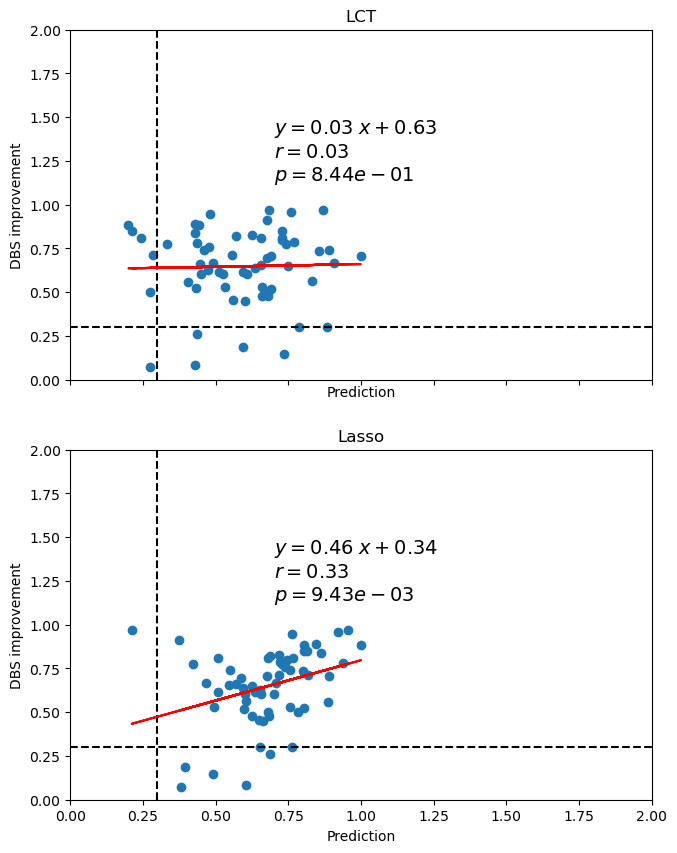

In [ ]:
results_ls_aug[results_ls_aug>1]=1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [ ]:
X_train

array([[[6.23422651e-01, 2.64581666e-01, 4.49489250e+00, ...,
         1.09805376e+03, 1.07861586e-01, 3.86850135e+00],
        [7.07204040e-01, 2.51968379e-01, 4.21360445e+00, ...,
         1.41413320e+03, 1.12230887e-01, 5.98268180e+00],
        [5.03635702e-01, 2.66907366e-01, 2.74295413e+00, ...,
         4.83334004e+02, 1.11710598e-01, 6.91443598e+00],
        [5.71841701e-01, 2.73824690e-01, 2.72232020e+00, ...,
         5.98950840e+02, 1.00904351e-01, 1.09777488e+01]],

       [[6.75531052e-01, 2.61072617e-01, 4.68221467e+00, ...,
         2.82634846e+03, 1.68547222e-01, 5.74054032e+00],
        [7.19206300e-01, 2.41525389e-01, 4.33607522e+00, ...,
         5.24228887e+03, 1.57014881e-01, 1.07837181e+01],
        [4.66511309e-01, 2.46827508e-01, 2.93421966e+00, ...,
         3.60459641e+02, 1.25526323e-01, 5.84215748e+00],
        [5.26933540e-01, 2.55784388e-01, 2.85560335e+00, ...,
         5.36598604e+02, 1.23927948e-01, 6.78300846e+00]],

       [[6.69842999e-01, 2.99891174e

In [ ]:
Js = []
aug = False
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,None,None,None,None,None,None,None,None,None,False,False,False)
    # X0_ss0 = X_train
    # X_test_ss0 = X_test

    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    np.random.seed(rs)
    # for jj in np.arange(2,cvn):
      # # Resample to avoid stratification errors
      # while np.sum(y_cat) < cvn: #2*np.sum(y_cat)-1
      #   np.random.seed(rs)
      #   idyr = np.random.choice(np.asarray(idy).ravel())
      #   X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
      #   y_train = np.append(y_train,y_train[idyr])
      #   y_cat = y_train <= 0.3
      #   rs = rs+1
      #   print('Resampled to size',y_train.shape)
      # if aug == True:
      #   y_train_n = y_train+(sigma/mu)*np.random.normal(0,4*sigma,1)
      #   y_train = np.hstack((y_train,y_train_n))
      #   y_cat = y_train <= 0.3
      #   X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      # with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      #   # Feature selection
      #   warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,min_features_to_select=100)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      print(sel.score(X0_ss0,y_train))
      X0_ss = X0_sst
      est_ls = lasso.fit(X0_ss,y_train)
      cv_scores[jj] = est_ls.score(X0_ss,y_train)
      print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)

      # # Break any ties
      # if np.sum(cv_scores == best_cv) > 1:
      #   cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
      #   for jjj in (cv_scores == cv_scores[best_cv]):
      #     if jjj > 0:
      #       skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
      #       skf_gen = skf_g.split(X0_ss0,y_cat) 
      #       X0_sst = sel.fit_transform(X0_ss0,y_train)
      #       X0_ss = X0_sst
      #       lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
      #       est_ls = lasso.fit(X0_ss,y_train)
      #       cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
      #   best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls_aug[c] = est_ls.predict(X_test_ss)
    print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
              'for case',subsc[j], 'with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
  
    c=c+1

      

  


Label distribution of: 0.6321651351845912 0.243410834901426 -0.8387907971979701
0.20427406594950293
LassoCV score for 2 is [0.20427407] from dataset of size (39, 100)
0.39967468464965616
LassoCV score for 3 is [0.39967468] from dataset of size (39, 4381)
0.05594078364203625
LassoCV score for 4 is [0.05594078] from dataset of size (39, 6381)
Lasso predicts 0.5226 for case 1.0 with 0.71 and selected CV 3
Label distribution of: 0.6374905789715734 0.2427320578527609 -0.9067651170238487
0.0
LassoCV score for 2 is [0.] from dataset of size (39, 1381)
0.12116441666227407
LassoCV score for 3 is [0.12116442] from dataset of size (39, 3381)
0.0
LassoCV score for 4 is [0.] from dataset of size (39, 5381)
Lasso predicts 0.6965 for case 2.0 with 0.5 and selected CV 3
Label distribution of: 0.6332170746980691 0.2436462015136146 -0.8486238582409412
0.2600638326353696
LassoCV score for 2 is [0.26006383] from dataset of size (39, 1381)
0.5904717325795659
LassoCV score for 3 is [0.59047173] from dataset

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=0.

In [ ]:
jjj

array([ True])

In [ ]:

util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [ ]:
pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
per_change = np.repeat(per_change,r)
plt.rcParams['figure.figsize'] = [20, 5]
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
col = np.where(per_change <= 0.3,'orange','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].text(0.6,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=16)
ax[0].set_ylabel('True improvement',fontsize=16)

col = np.where(per_change <= 0.3,'orange','blue')
ax[1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1].plot(results_ls,y_model,color='r')
ax[1].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Lasso',fontsize=16)
ax[1].set_xlabel('Prediction',fontsize=16)
col = np.where(per_change <= 0.3,'orange','blue')
ax[2].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[2].plot(results_ls_aug,y_model,color='r')
ax[2].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[2].transAxes,fontsize=16) 
ax[2].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].set_title('Noise Compensated Lasso',fontsize=16)
plt.ylim([0,1.25])
plt.xlim([0,1.25])
plt.style.use('default')

In [ ]:
# np.save('results_ls_aug_msw.npy',results_ls_aug)

In [ ]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# best fit of data
(mu, sigma) = stats.norm.fit(per_change)

# the histogram of the data
# zn, zbins, zpatches = plt.hist(per_change, bins=16, density=True)

n, bins, patches = plt.hist(per_change, bins='auto', density=True)

# add a 'best fit' line
y = norm.pdf(zbins, mu, sigma)
l = plt.plot(zbins, y, 'r', linewidth=2)

#plot
plt.xlabel('y')
plt.ylabel('f(y)')
plt.title(r'$\mathrm{Label \ distribution}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()